# October 29-31, 2022: ISCs during `Near` vs ISCs during `Far` segments

In [1]:
import bct
import csv
import os
import pickle
import random
import sys
from copy import deepcopy
from itertools import combinations
from os.path import join as pjoin

import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from brainiak.isc import compute_correlation, squareform_isfc, compute_summary_statistic
from scipy import signal
from tqdm.notebook import tqdm
from scipy.spatial.distance import squareform

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/oct22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.NAMES = ['NEAR', 'FAR']
args.TRIAL_LEN = 15
args.near_thresh = [0.77, 0.9]
args.near_width = 7.0
args.far_thresh = [0.8, 0.99]
args.far_width = 6.8
args.min_window_length = 6
args.SEGMENT_TRS = np.arange(0, args.min_window_length)
args.min_trials = {'NEAR':10, 'FAR':12} #{'NEAR':14, 'FAR':45}
args.TR = 1.25

In [3]:
args.proj_dir = proj_dir
# stimulus file
# copied Joyneel's pkl file 
with open(
    f"/home/govindas/network_dynamics/data/emoprox2/data/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)
# motion_df

args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/emoprox2/data/rois_{args.roi_set_name}"
)

# exploratory data
args.subjects = np.unique(motion_df.pid.values)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.27 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


## testing definition of NEAR and FAR segments

In [4]:
subj = args.explor_subjects[10]

subj_motion_df = motion_df.loc[motion_df.pid.isin([subj])]
proximity = np.hstack(
    subj_motion_df['proximity'].to_list()
).T
direction = np.hstack(
    subj_motion_df['direction'].to_list()
).T
ts = np.loadtxt(
    f"{args.main_data_dir}/CON{subj}/CON{subj}_resids_REML.1D"
).T

assert (proximity.shape[0] == ts.shape[0])
assert (direction.shape[0] == ts.shape[0])
assert (np.sum(np.isnan(ts)) == 0)

# censor proximity and direction 
censor_TRs = ts[:,0] == 0
proximity[censor_TRs] = 0.0
direction[censor_TRs] = 0.0

# near peaks
near_peaks, _ = signal.find_peaks(
    proximity, 
    height=args.near_thresh, 
    width=args.near_width
)

# far peaks
far_peaks, _ = signal.find_peaks(
    1 - proximity,
    height=args.far_thresh, 
    width=args.far_width
)

Text(0.5, 0, 'peaks')

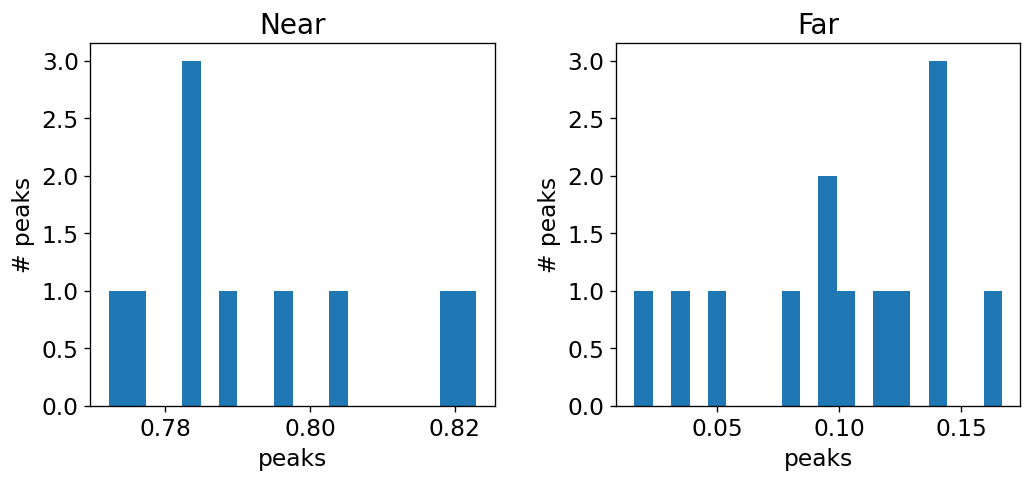

In [5]:
# distribution of peak heights
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 4*1), dpi=120)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=0.3, hspace=0.0
)

ax = axs[0]
ax.hist(
    proximity[near_peaks],
    bins=20,
    label='near'
)
ax.set_title(f"Near")
ax.set_ylabel(f"# peaks")
ax.set_xlabel(f"peaks")

ax = axs[1]
ax.hist(
    proximity[far_peaks],
    bins=20,
    label='far'
)
ax.set_title(f"Far")
ax.set_ylabel(f"# peaks")
ax.set_xlabel(f"peaks")

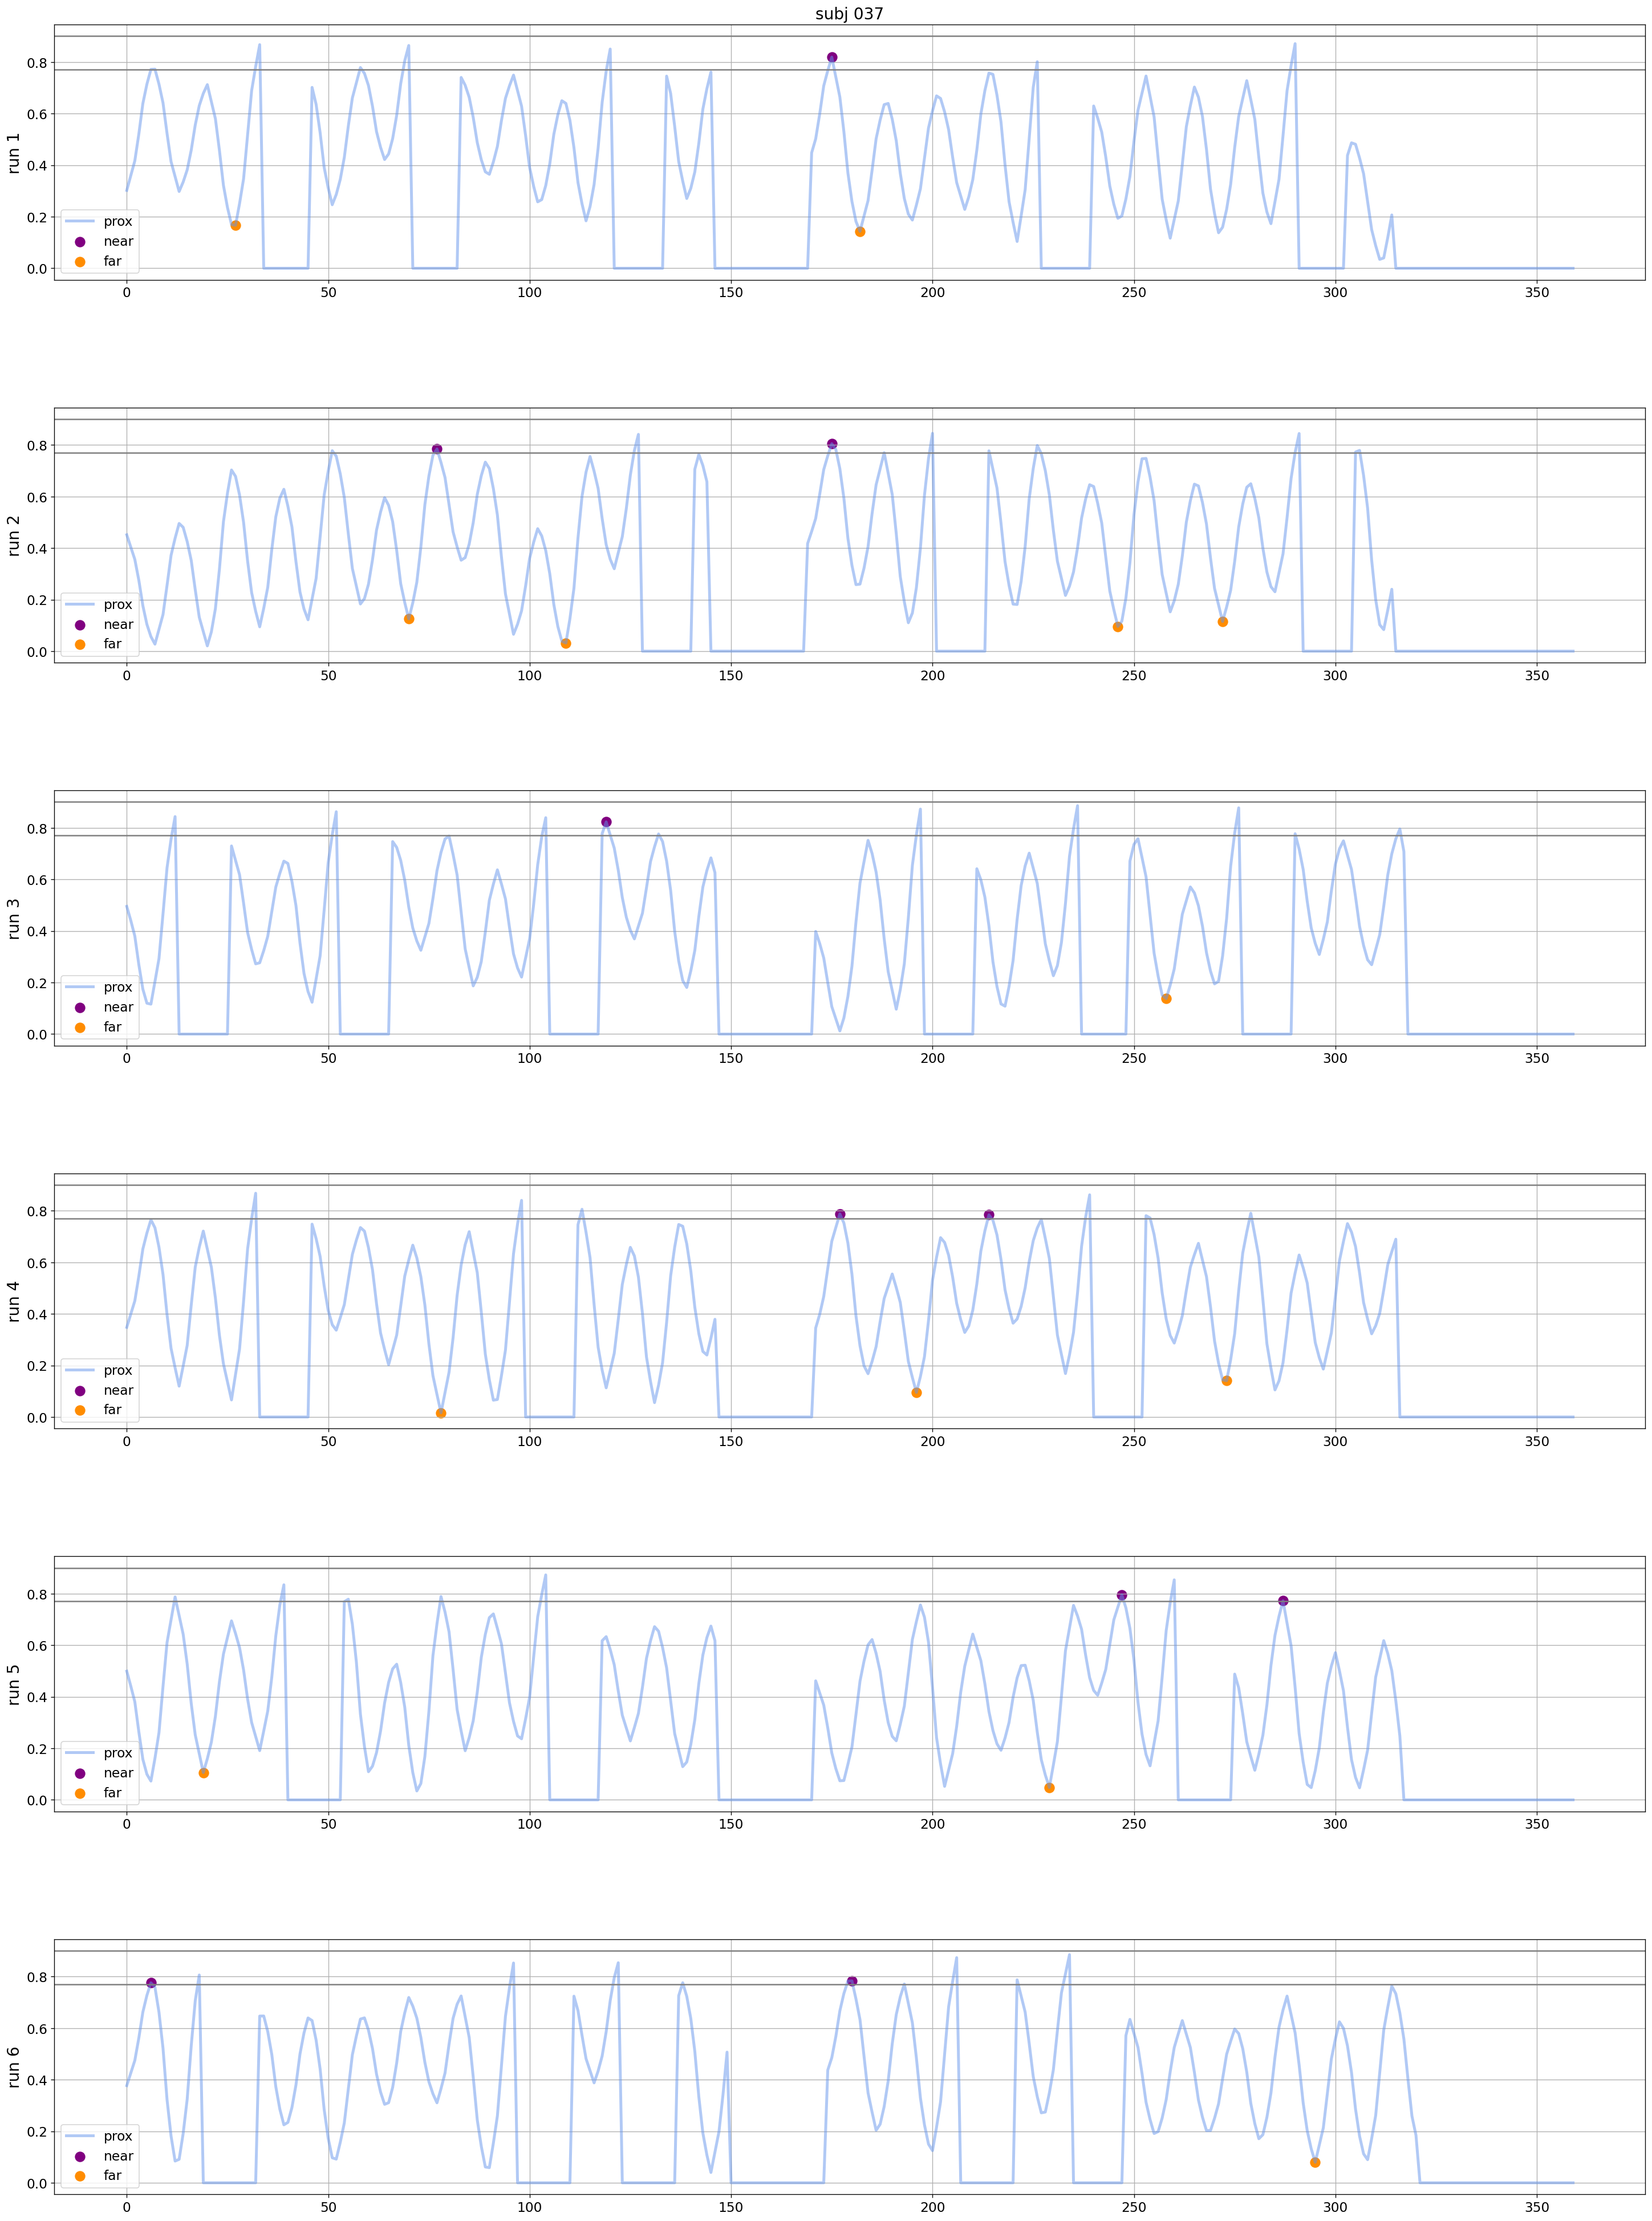

In [6]:
nrows, ncols = len(proximity) // 360, 1
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(30*ncols, 7*nrows),
    dpi=120,
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx in range(nrows):
    ax = axs[idx]

    if idx == 0: ax.set_title(f"subj {subj}")
    ax.set_ylabel(f"run {idx+1}", size='large')

    # proximity
    pr_run_idxs = np.arange(360) + idx*360
    pr = proximity[pr_run_idxs]
    ax.plot(
        pr,
        linewidth=3,
        color='cornflowerblue',
        alpha=0.5,
        label='prox'
    )

    # near  band
    for y in args.near_thresh:
        ax.axhline(y, xmin=0, xmax=len(pr), color='grey')

    # near peaks
    in_run_idxs = (near_peaks >= idx*360) & (near_peaks < (idx+1)*360)
    nm = near_peaks[in_run_idxs]
    ax.scatter(
        nm % 360, 
        proximity[nm],
        s=100,
        color='purple',
        label='near'
    )

    # # 1 - proximity
    # ax.plot(
    #     1 - pr,
    #     linewidth=3,
    #     color='firebrick',
    #     alpha=0.5,
    #     label='1 - prox',
    # )

    # far peaks
    in_run_idxs = (far_peaks >= idx*360) & (far_peaks < (idx+1)*360)
    fm = far_peaks[in_run_idxs]
    ax.scatter(
        fm % 360,
        proximity[fm],
        s=100,
        color='darkorange',
        label='far'
    )

    ax.grid(True)
    ax.legend()

In [7]:
# distances between any two peaks, 
# discard close enough peaks
peaks = np.concatenate([near_peaks, far_peaks])
sorted_peaks = np.sort(peaks)
sorted_idxs = np.argsort(peaks)

revert_sort_idxs = np.argsort(sorted_idxs)

diff_peaks = np.diff(np.append(0, sorted_peaks))
keep_peaks_idxs = (diff_peaks >= args.min_window_length)[revert_sort_idxs]
print(keep_peaks_idxs)

near_peaks = peaks[:len(near_peaks)][keep_peaks_idxs[:len(near_peaks)]]
far_peaks = peaks[-len(far_peaks):][keep_peaks_idxs[-len(far_peaks):]]
near_peaks, far_peaks

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


(array([ 175,  437,  535,  839, 1257, 1294, 1687, 1727, 1806, 1980]),
 array([  27,  182,  430,  469,  606,  632,  978, 1158, 1276, 1353, 1459,
        1669, 2095]))

## dataset

In [8]:
X, lens = dataset_utils.get_emo2_near_vs_far_responses(args, motion_df)
# for name in X.keys():
#     print(f"{name}---, {len(X[name])}")
#     for idx_subj in range(len(X[name])):
#         print(len(X[name][idx_subj]))

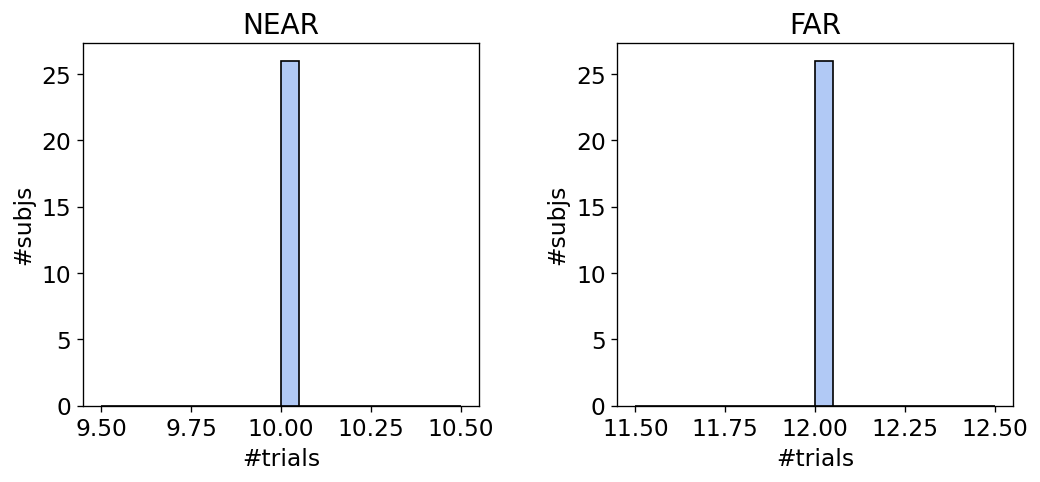

In [9]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=False, 
    dpi=120
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=0.35, hspace=None
)

for idx, name in enumerate(lens.keys()):
    ax = axs[idx]

    sns.histplot(
        x=lens[name],
        kde=True,
        stat='count',
        bins=20,
        ax=ax,
        color='cornflowerblue',
        line_kws={'linewidth':3},
    )


    ax.set_title(name)
    ax.set_xlabel(f"#trials")
    ax.set_ylabel(f"#subjs")

In [10]:
ts = dataset_utils.get_emo2_near_vs_far_timeseries(args, X, subj_axis=-1)

In [11]:
ts['NEAR'].shape, ts['FAR'].shape

((60, 45, 26), (72, 45, 26))

## ISC

100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


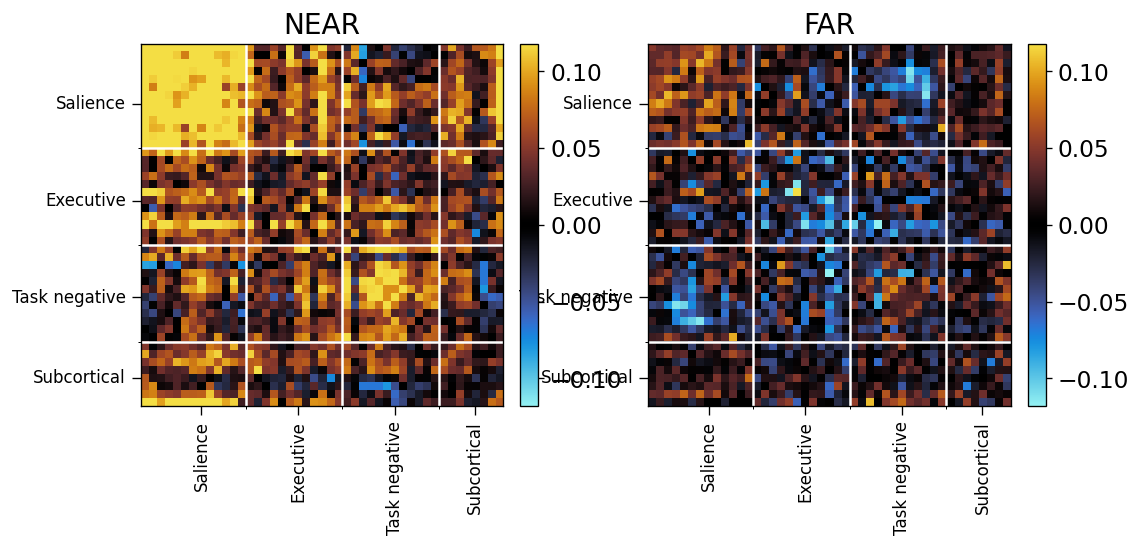

In [12]:
# ISC matrices 
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise=False
args.vectorize_isfcs = True
args.n_bootstraps = 1000
args.positive_only = False
(
    corrs, 
    bootstraps, 
    rois
) = isc_utils.get_isfcs(
    args, 
    ts
)
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=False
)
isc_utils.plot_emo2_near_vs_far_isfcs(
    args, 
    observed_isfcs, 
    significant_rois
)

1it [00:02,  2.67s/it]


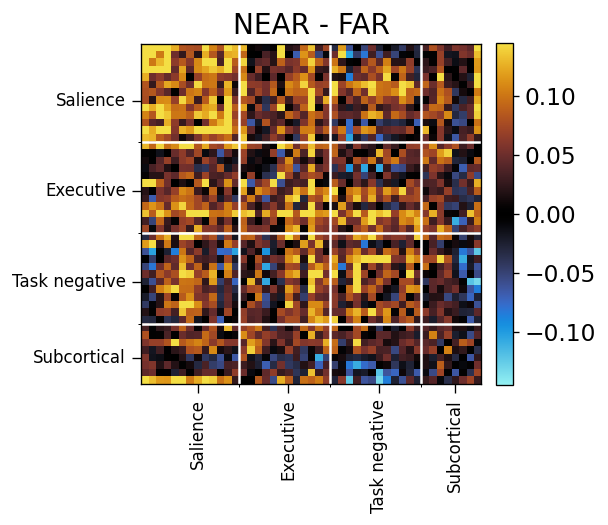

In [13]:
# difference ISCs
stats_results = isc_utils.get_comparison_stats(
    args, 
    corrs,
    paradigm='emo2_near_vs_far',
    how_pairs='all_combs',
)
(
    diff_isfcs, 
    diff_pvals
) = isc_utils.get_diff_isfcs(
    args, 
    stats_results, 
    significant_rois, 
    threshold_mats=False
)
isc_utils.plot_emo2_isfc_comparisons(
    args, 
    corrs, 
    diff_isfcs, 
)

In [14]:
# bootstrap ISCs
(
    bootstrap_isfcs, 
    all_isfcs
) = isc_utils.get_bootstrap_distribution_isfcs(
    args, 
    observed_isfcs, 
    bootstraps,
)

In [15]:
# separate positive and negative weights
(
    all_isfcs_pos, all_isfcs_neg,
    all_sq_isfcs_pos, all_sq_isfcs_neg
) = isc_utils.separate_pos_neg_weights(
    args, 
    all_isfcs, 
    significant_rois
)